In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

In [2]:
def func(x, const1, const2,const3,init,lapse1,lapse2,lapse3):
    bound1 = init
    bound2 = bound1+lapse1
    bound3 = bound2+lapse2
    bound4 = bound3+lapse3
    a1 = (const2-const1)/(bound2-bound1)
    b1 = const1-a1*bound1
    a2= (const3-const2)/(bound4-bound3)
    b2 = const3-a2*bound4
    bool1 = x<=bound1
    bool2 = (x <=bound2)*(x>bound1)
    bool3 = (x <=bound3)*(x>bound2)
    bool4 = (x <=bound4)*(x>bound3)
    bool5 = x>bound4
    return(const1*bool1+(a1*x+b1)*bool2+const2*bool3+(a2*x+b2)*bool4+const3*bool5)


In [3]:
from scipy import special
def func2(x,lapse, lapse2,c,d,e):
    return(-c*(special.erf(e*(x-lapse))-special.erf(e*(x-lapse-lapse2)))+d)
def func3(x, lapse,lapse2,c,d,e,lapse4):
    return(-c*(special.erf(e*(x-lapse))-special.erf(e*(x-(lapse+lapse2))))+d+c*(special.erf(e*(x-(lapse+lapse2)))-special.erf(e*(x-(lapse+lapse2+lapse4)))))
def func4(x, lapse,lapse2,c,d,e,lapse4):
    return(-c*(special.erf(e*(x-lapse))-special.erf(e*(x-(lapse+lapse2))))+d+c*(special.erf(e*(x-(lapse-lapse4)))-special.erf(e*(x-(lapse)))))


0.9550673207634218 0.9986344586416595


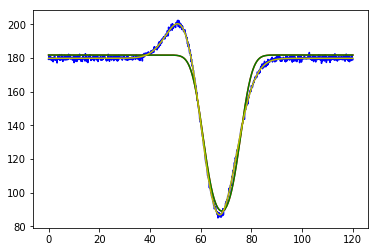

In [4]:
plt.close('all')
xdata = np.linspace(0, 120, 1000)

y = func4(xdata, 60,10,120,180,0.1,5)

np.random.seed(1729)

y_noise = 1* np.random.normal(size=xdata.size)

ydata = y + y_noise
p0a=[60,10,100,180,0.1]
popt1, pcov = curve_fit(func2, xdata, ydata,bounds = ([0,0,0,0,0],[120,120,200]+2*[np.inf]),p0=p0a)
p0b=list(popt1)+[10]
popt2, pcov = curve_fit(func3, xdata, ydata,bounds = ([0,0,0,0,0,0],[120,120,200]+2*[np.inf]+[120]),p0=p0b)
residuals = ydata- func3(xdata, *popt2)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((ydata-np.mean(ydata))**2)
r_squared1 = 1 - (ss_res / ss_tot)
popt3, pcov = curve_fit(func4, xdata, ydata,bounds = ([0,0,0,0,0,0],[120,120,200]+2*[np.inf]+[120]),p0=p0b)
residuals = ydata- func4(xdata, *popt3)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((ydata-np.mean(ydata))**2)
r_squared2 = 1 - (ss_res / ss_tot)
print(r_squared1,r_squared2)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(xdata, ydata, 'b-', label='data')
ax.plot(xdata, func2(xdata, *popt1), 'r-')
ax.plot(xdata, func3(xdata, *popt2), 'g-')
ax.plot(xdata, func4(xdata, *popt3), 'y-')

In [4]:
%matplotlib widget

import sys  
sys.path.insert(0, '/home/cbisot/pycode/MscThesis/')
import pandas as pd
from sample.util import get_dates_datetime, get_dirname, get_plate_number, get_postion_number

import ast
from sample.plotutil import plot_t_tp1
from scipy import sparse
from datetime import datetime
from sample.pipeline.functions.node_id import orient
import pickle
import scipy.io as sio
from pymatreader import read_mat
from matplotlib import colors
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import frangi
from skimage import filters
from random import choice
import scipy.sparse
import os
from sample.pipeline.functions.extract_graph import from_sparse_to_graph, generate_nx_graph, sparse_to_doc
from skimage.feature import hessian_matrix_det
from sample.pipeline.functions.experiment_class_surf import Experiment, Edge, Node
from sample.paths.directory import run_parallel, find_state, directory_scratch, directory_project
from sample.notebooks.analysis.util import *
from scipy import stats
from scipy.ndimage.filters import uniform_filter1d
from statsmodels.stats import weightstats as stests

In [5]:
directory = "/projects/0/einf914/data/"
exp = get_exp((10,104,104),directory)

begin = 2020-12-17 08:39:00 
  end = 2020-12-17 08:39:00


In [6]:
exp.load_compressed_skel()

In [14]:
from skimage.measure import profile_line
from sample.notebooks.analysis.util import *
# reg = [ 4.73083338e-02, -1.05856859e-03,  1.13917392e-02, -1.31659876e+01, 4.90631616e-03]
# intercept = 11.146111033029417
# reg2 = 1.27875045
# intercept 2 = -1.9359297656055041
def get_source_image(experiment,pos,t,local,force_selection = None):
    x,y=pos[0],pos[1]
    ims,posimg=experiment.find_image_pos(x,y,t,local)
    if force_selection is None:
        dist_border=[min([posimg[1][i],3000-posimg[1][i],posimg[0][i],4096-posimg[0][i]]) for i in range(posimg[0].shape[0])]
        j=np.argmax(dist_border)
    else:
        dist_last=[np.linalg.norm(np.array((posimg[1][i],posimg[0][i])) - np.array(force_selection)) for i in range(posimg[0].shape[0])]
        j=np.argmin(dist_last)
    return(ims[j],(posimg[1][j],posimg[0][j]))
def get_width_pixel(edge,index,im,pivot,before,after,t,size = 20,width_factor = 60,averaging_size = 100,threshold_averaging = 10):
    imtab=im
#     print(imtab.shape)
#     print(int(max(0,pivot[0]-averaging_size)),int(pivot[0]+averaging_size))
    threshold = np.mean(imtab[int(max(0,pivot[0]-averaging_size)):int(pivot[0]+averaging_size),int(max(0,pivot[1]-averaging_size)):int(pivot[1]+averaging_size)]-threshold_averaging)
    orientation=np.array(before)-np.array(after)
    perpendicular = [1,-orientation[0]/orientation[1]] if orientation[1]!=0 else [0,1]
    perpendicular_norm=np.array(perpendicular)/np.sqrt(perpendicular[0]**2+perpendicular[1]**2)
    point1=np.around(np.array(pivot)+width_factor*perpendicular_norm)
    point2=np.around(np.array(pivot)-width_factor*perpendicular_norm)
    point1=point1.astype(int)
    point2=point2.astype(int)
    p = profile_line(imtab, point1, point2,mode='constant')
    xdata = np.array(range(len(p)))
    ydata = np.array(p)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(xdata,ydata)
    p0a=[60,10,100,180,0.1]
    popt1, pcov = curve_fit(func2, xdata, ydata,bounds = ([0,0,0,0,0],[120,120,200]+2*[np.inf]),p0=p0a)
    p0b=list(popt1)+[10]
    popt2, pcov = curve_fit(func3, xdata, ydata,bounds = ([0,0,0,0,0,0],[120,120,200]+2*[np.inf]+[120]),p0=p0b)
    residuals = ydata- func3(xdata, *popt2)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((ydata-np.mean(ydata))**2)
    r_squared1 = 1 - (ss_res / ss_tot)
    popt3, pcov = curve_fit(func4, xdata, ydata,bounds = ([0,0,0,0,0,0],[120,120,200]+2*[np.inf]+[120]),p0=p0b)
    residuals = ydata- func4(xdata, *popt3)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((ydata-np.mean(ydata))**2)
    r_squared2 = 1 - (ss_res / ss_tot)
#     ax.plot(xdata, func2(xdata, *popt1), 'r-')
    if r_squared1>r_squared2:
        ax.plot(xdata, func3(xdata, *popt2), 'b-')
        popt=popt2
    else:
        ax.plot(xdata, func4(xdata, *popt3), 'b-')
        popt=popt3
    width_pix = popt[1]
#     print(popt1[1],width_pix)
#     p0=[165,100,165,45,10,10,10]
#     popt, pcov = curve_fit(func, xdata, ydata,bounds = ([-np.inf,-np.inf,-np.inf,-np.inf,0,0,0],np.inf),p0=p0)
#     width_pix = popt[-2]
#     ax.plot(xdata, func(xdata, *popt), 'r-')
#     derivative = [p[i+1]-p[i] for i in range(len(p)-1)]
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     ax.plot([np.mean(derivative[5*i:5*i+5]) for i in range(len(derivative)//5)])
#     problem=False
#     arg = len(p)//2
#     if p[arg]>threshold:
#         arg = np.argmin(p)
# #     we_plot=randrange(1000)
#     while  p[arg]<=threshold:
#         if arg<=0:
# #             we_plot=50
#             problem=True
#             break
#         arg-=1
#     begin = arg
#     arg = len(p)//2
#     if p[arg]>threshold:
#         arg = np.argmin(p)
#     while  p[arg]<=threshold:
#         if arg>=len(p)-1:
# #             we_plot=50
#             problem=True
#             break
#         arg+=1
#     end = arg
# #     print(end-begin,threshold)
#     print(np.linalg.norm(point1-point2),len(p),width_pix)
    return(np.linalg.norm(point1-point2)*(width_pix)/len(p))

def get_width_edge(edge,resolution,t,local=False, threshold_averaging = 10):
    pixel_conversion_factor = 1.725
    pixel_list = edge.pixel_list(t)
    pixels = []
    indexes = []
    source_images = []
    poss = []
    widths={}
    if len(pixel_list)>3*resolution:
        for i in range(0,len(pixel_list)//resolution):
            index = i*resolution
            indexes.append(index)
            pixel = pixel_list[index]
            pixels.append(pixel)
            source_img,pos = get_source_image(edge.experiment,pixel,t,local)
            source_images.append(source_img)
            poss.append(pos)
    else:
        indexes = [0,len(pixel_list)//2,len(pixel_list)-1]
        for index in indexes:
            pixel = pixel_list[index]
            pixels.append(pixel)
            source_img,pos = get_source_image(edge.experiment,pixel,t,local)
            source_images.append(source_img)
            poss.append(pos)
#     print(indexes)
    for i, index in enumerate(indexes[1:-1]):
        source_img = source_images[i+1]
        pivot = poss[i+1]
        _,before = get_source_image(edge.experiment,pixels[i],t,local,pivot)
        _,after = get_source_image(edge.experiment,pixels[i+2],t,local,pivot)
#         plot_t_tp1([0,1,2],[],{0 : pivot,1 : before, 2 : after},None,source_img,source_img)
        width = get_width_pixel(edge,index,source_img,pivot,before,after,t,threshold_averaging = threshold_averaging)
#         print(width*pixel_conversion_factor)
        widths[pixel_list[index]]=width*pixel_conversion_factor
#         if i>=1:
#             break
    edge.experiment.nx_graph[t].get_edge_data(edge.begin.label,edge.end.label)['width'] = widths
    return(widths)      

In [12]:
np.mean(list(widths.values()))

NameError: name 'widths' is not defined

In [19]:
plt.close("all")
node1 = 940
node2 = 890
widths = get_width_edge(Edge(Node(node1,exp),Node(node2,exp),exp),50,0)
print(np.mean(list(widths.values())))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

28.00609508255842


In [27]:
table

,edge,realx,realy,real_scale,real_w,extracted_w,Extracted_other,Extracted_gaussian
0,2040;1749,1.23,0.00,1.88,6.542553,52.0,16.165781,47.573749
1,2040;2378,1.08,0.59,1.84,6.688316,56.0,17.855333,51.382735
2,2040;1953,1.07,0.19,1.84,5.906186,46.0,13.672368,36.288240
3,1991;2237,0.34,1.22,1.84,6.883104,63.0,22.090684,54.975664
4,2497;2329,0.24,1.47,1.84,8.094908,62.0,21.876426,58.588916
5,2497;2459,0.97,0.43,1.84,5.766507,56.0,18.461902,48.734690
6,3765;4017,0.34,1.71,1.84,9.475400,61.0,16.352954,48.025684
7,3187;3179,0.93,0.29,1.96,4.970236,30.6,11.850233,NaN
8,3116;3187,0.32,1.35,1.96,7.078610,51.0,13.120323,NaN
9,3187;3325,0.61,1.59,1.96,8.688762,53.0,14.607233,NaN


In [8]:
import pandas as pd
table = pd.read_excel('width_calib.xls')
edges= [(int(edge.split(';')[0]),int(edge.split(';')[1])) for edge in table['edge']]
widths_real=[float(width) for width in table['real_w']]

In [12]:
widths_real[10]

8.854940558759782

In [9]:
widths_real_select = []
widths_calculated=[]
for i,edge in enumerate(edges):
    if edge!=(2852,2972):
        node1 = edge[0]
        node2 = edge[1]
        widths = get_width_edge(Edge(Node(node1,exp),Node(node2,exp),exp),50,0)
        widths_real_select.append(widths_real[i])
        widths_calculated.append(np.mean(list(widths.values())))


In [10]:
from sklearn.linear_model import LinearRegression

X3 = np.array(widths_calculated,dtype=np.float).reshape(-1,1)
y = widths_real_select
reg3 = LinearRegression().fit(X3, y)


In [21]:
reg3.coef_,reg3.intercept_

(array([0.02579671]), 5.838132478576073)

In [13]:
plt.close('all')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(widths_calculated,widths_real_select)
ax.plot(np.linspace(0,100,100),reg3.coef_[0]*np.linspace(0,100,100)+reg3.intercept_)
ax.set_xlabel('width_calculated(um)')
ax.set_ylabel('width_real(um)')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0, 0.5, 'width_real(um)')

In [522]:
Node(2329,exp).show_source_image(0,0)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [18]:
(9/14)/4096*10000

1.5694754464285716

In [518]:
Node(2329,exp).show_source_image(0,0)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [513]:
Node(4017,exp).show_source_image(0,0)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …